In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd
import corner
import scipy.stats as stats
from tqdm import tqdm

from msc.plot_utils import set_size
from msc.config_utils import config

plt.style.use(['science', 'no-latex'])
plt.viridis()


<Figure size 252x189 with 0 Axes>

In [2]:
class PercentileOfScore(object):
    """a vectorized implementation of stats.percentileofscore"""
    def __init__(self, aList):
        self.a = np.array( aList )
        self.a.sort()
        self.n = float(len(self.a))
        self.pct = self.__rank_searchsorted_list
    # end def __init__

    def __rank_searchsorted_list(self, score_list):
        adx = np.searchsorted(self.a, score_list, side='right')
        pct = []
        for idx in adx:
            # Python 2.x needs explicit type casting float(int)
            pct.append( (float(idx) / self.n) * 100.0 )

        return pct
    # end def _rank_searchsorted_list
# end class PercentileOfScore

In [3]:
# generate data
n_samples = 100 * np.array([600, 400, 1])
centers = np.array([[0], [3], [5]])
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=1, random_state=0)


In [4]:
# discretize for histogram
bins = np.linspace(-8, 8, 100, endpoint=True)
count, bins = np.histogram(X, bins=bins)


In [5]:
# fit density estimation
gmm = GaussianMixture(2)
gmm.fit(X)


GaussianMixture(n_components=2)

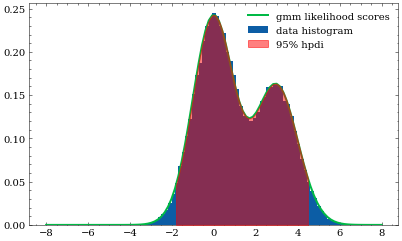

In [6]:
# plot density log likelihood
width = 478  # pt
fig, axes = plt.subplots(1, figsize=set_size(width))

theta = bins
scores = gmm.score_samples(theta.reshape(-1, 1))

axes.hist(X, bins=bins, label='data histogram', density=True, zorder=2)
axes.plot(theta, np.exp(scores), label='gmm likelihood scores', lw=2, zorder=2)

# plot highest posterior density interval 
ci = numpyro.diagnostics.hpdi(X, 0.95)
hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))

axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)
axes.legend()

plt.show()

In [7]:
ci

array([[-1.80219269],
       [ 4.48082753]])

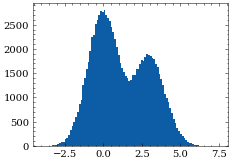

In [8]:
plt.hist(np.array(gmm.sample(100000)[0]).reshape(-1,1), bins=100);

sampling from gmm with mcmc

In [9]:
def mh_mcmc(N=int(1e5)):
  samples = []
  theta = np.array([0])
  for i in tqdm(range(N)):
    proposal_func = lambda x: stats.norm.rvs(loc=x, scale=1)
    theta_prime = np.array([proposal_func(theta)]).reshape(1,1)
    log_likelihood = gmm.score(theta_prime)
    r = np.random.uniform()
    if log_likelihood > np.log(r):
      theta = theta_prime
    samples.append(theta)
  return np.vstack(samples)

In [10]:
mcmc_samples = mh_mcmc()

100%|██████████| 100000/100000 [00:54<00:00, 1821.51it/s]


In [11]:
gmm_samples = gmm.sample(1e5)[0].reshape(-1, 1)

In [12]:
stats.describe(mcmc_samples)

DescribeResult(nobs=100000, minmax=(array([-3.31104172]), array([6.0632771])), mean=array([1.16037232]), variance=array([3.2760448]), skewness=array([0.23954971]), kurtosis=array([-0.87816781]))

In [13]:
stats.describe(gmm_samples)

DescribeResult(nobs=100000, minmax=(array([-4.0170187]), array([6.90607849])), mean=array([1.20481707]), variance=array([3.17307778]), skewness=array([0.23464629]), kurtosis=array([-0.87255957]))

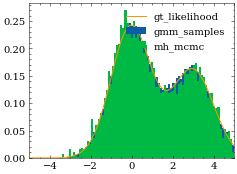

In [14]:
plt.hist(gmm_samples, bins=np.linspace(-5, 5, 100),  density=True, label='gmm_samples')
plt.hist(mcmc_samples, bins=np.linspace(-5, 5, 100), density=True, label='mh_mcmc');
# plt.yscale('log')
plt.xlim(-5, 5)
x = np.linspace(-5, 5, 100)
plt.plot(x, np.exp(gmm.score_samples(x.reshape(-1, 1))), label='gt_likelihood')
plt.legend()
plt.tight_layout();

In [15]:
mcmc_ci = numpyro.diagnostics.hpdi(mcmc_samples, 0.95)
mcmc_ci
# hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
# hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))
# axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)

array([[-1.92341633],
       [ 4.38873402]])

In [16]:
gmm_ci = numpyro.diagnostics.hpdi(gmm_samples, 0.95)
gmm_ci

array([[-1.799561  ],
       [ 4.46683658]])

In [17]:
mse = np.mean((mcmc_ci - gmm_ci)**2)
mse

0.01072007593839314

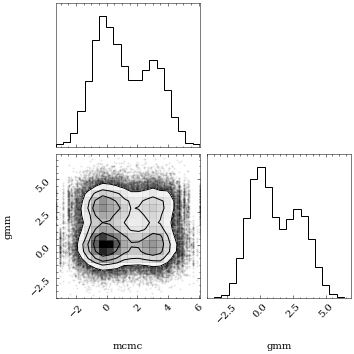

In [18]:
corner.corner(np.hstack([mcmc_samples, gmm_samples]), labels=['mcmc', 'gmm']);

In [19]:
stats.kstest(mcmc_samples.squeeze(), gmm_samples.squeeze())

KstestResult(statistic=0.0199, pvalue=1.2454734745539656e-17)

In [20]:
1.63/np.sqrt(1e5)

0.005154512586074457

## convert to p-value

In [21]:
def bsle_transform(samples):
    samples = np.where(samples)

In [22]:
bsle_samples = mcmc_samples

In [23]:
values, counts = np.unique((np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])), return_counts=True)
values, counts

(array([False,  True]), array([ 5037, 94963]))

<BarContainer object of 2 artists>

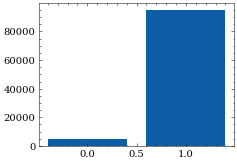

In [24]:
plt.bar(*np.unique((np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])), return_counts=True))

In [25]:
np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [26]:
inliers = mcmc_samples[np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])]
outliers = mcmc_samples[np.logical_not(np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1]))]


In [27]:
outliers.shape

(5037,)

Text(0.5, 1.0, 'outliers')

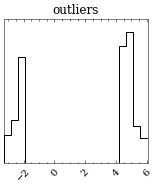

In [28]:
corner.corner(outliers.reshape(-1, 1));
plt.title('outliers')

Text(0.5, 1.0, 'inliers')

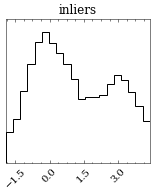

In [29]:
corner.corner(inliers.reshape(-1, 1));

plt.title('inliers')

In [30]:
len(outliers)

5037

In [31]:
samples_df = pd.DataFrame(mcmc_samples, columns=['x'])

In [32]:
samples_df['pdf_E'] = gmm.score_samples(samples_df['x'].to_numpy().reshape(-1, 1))

In [33]:
samples_df['P_E'] = PercentileOfScore(samples_df['pdf_E'].to_numpy()).pct(samples_df['pdf_E'].to_numpy())

In [34]:
samples_df['not_S'] = np.logical_and(mcmc_ci[0] < samples_df['x'].to_numpy(), samples_df['x'].to_numpy() < mcmc_ci[1])

In [35]:
samples_df.loc[samples_df['not_S'], 'P_E_|_not_S'] = PercentileOfScore(samples_df.loc[samples_df['not_S'], 'pdf_E'].to_numpy()).pct(samples_df.loc[samples_df['not_S'], 'pdf_E'].to_numpy())

In [36]:
samples_df

,x,pdf_E,P_E,not_S,P_E_|_not_S
0,0.000000,-1.415673,99.695,True,99.678822
1,0.000000,-1.415673,99.695,True,99.678822
2,0.000000,-1.415673,99.695,True,99.678822
3,0.074411,-1.418920,96.315,True,96.119541
4,0.240605,-1.445028,88.666,True,88.064825
...,...,...,...,...,...
99995,1.091059,-1.877469,43.940,True,40.966482
99996,1.091059,-1.877469,43.940,True,40.966482
99997,0.778154,-1.681878,66.307,True,64.519866
99998,0.778154,-1.681878,66.307,True,64.519866


In [37]:
def get_p_S_given_t(t):
    full_area = 

SyntaxError: invalid syntax (562892.py, line 2)